## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [47]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [48]:
train, test = keras.datasets.cifar10.load_data()

In [49]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [50]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [51]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [52]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
BEST = [True, False]
WEIGHTS = [True, False]

In [53]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint

#save_best_only: 只保存最好的模型,也可以都保存
#save_weights_only: 若设置为True，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）

In [54]:
results = {}
for i in BEST:
    for j in WEIGHTS:
        keras.backend.clear_session()
        name_tag = "BEST=%s, WEIGHTS=%s" % (i,j)
        print(name_tag)
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model_ckpt = ModelCheckpoint(filepath="./%s.h5" % (name_tag),
                             monitor="val_loss",
                             save_best_only=i,
                             save_weights_only=j)
        
        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True,
                  callbacks=[model_ckpt]
                 )

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
        


        # Load back
        if j == True:
            model.load_weights("./%s.h5" % (name_tag))
        else:        
            model = keras.models.load_model("./%s.h5" % (name_tag))
        loss_loadback, acc_loadback = model.evaluate(x_test, y_test)
        
        results[name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'loss_loadback': loss_loadback,
                             'acc_loadback': acc_loadback}

BEST=True, WEIGHTS=True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)            

Epoch 50/50
10000/10000 [==============================] - 1s 67us/step
BEST=True, WEIGHTS=False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________

50000/50000 [==============================] - 4s 90us/step - loss: 0.5272 - acc: 0.8498 - val_loss: 1.6675 - val_acc: 0.4814
Epoch 49/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5137 - acc: 0.8537 - val_loss: 1.6804 - val_acc: 0.4822
Epoch 50/50
10000/10000 [==============================] - 1s 79us/step
BEST=False, WEIGHTS=True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________________

50000/50000 [==============================] - 4s 90us/step - loss: 0.5513 - acc: 0.8392 - val_loss: 1.6322 - val_acc: 0.4944
Epoch 47/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5357 - acc: 0.8463 - val_loss: 1.6384 - val_acc: 0.4904
Epoch 48/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.5194 - acc: 0.8509 - val_loss: 1.6536 - val_acc: 0.4886
Epoch 49/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.5026 - acc: 0.8595 - val_loss: 1.6835 - val_acc: 0.4865
Epoch 50/50
10000/10000 [==============================] - 1s 64us/step
BEST=False, WEIGHTS=False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
________________________________

50000/50000 [==============================] - 5s 91us/step - loss: 0.5971 - acc: 0.8202 - val_loss: 1.6185 - val_acc: 0.4875
Epoch 45/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5792 - acc: 0.8282 - val_loss: 1.6438 - val_acc: 0.4868
Epoch 46/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5632 - acc: 0.8332 - val_loss: 1.6432 - val_acc: 0.4872
Epoch 47/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5441 - acc: 0.8406 - val_loss: 1.6561 - val_acc: 0.4891
Epoch 48/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.5291 - acc: 0.8474 - val_loss: 1.6641 - val_acc: 0.4861
Epoch 49/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.5128 - acc: 0.8541 - val_loss: 1.6752 - val_acc: 0.4885
Epoch 50/50
10000/10000 [==============================] - 1s 75us/step


In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_results(i, cond):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color='b')
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '-', label=cond, color='g')
    plt.hlines(y=results[cond]['loss_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.title("Loss")
    plt.ylim([0, 2.5])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color='b')
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '-', label=cond, color='g')
    plt.hlines(y=results[cond]['acc_loadback'], xmin=0, xmax=len(train_loss), colors='r', linestyles='--')
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

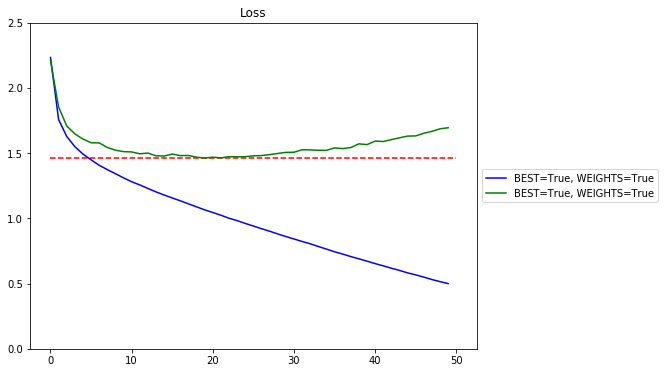

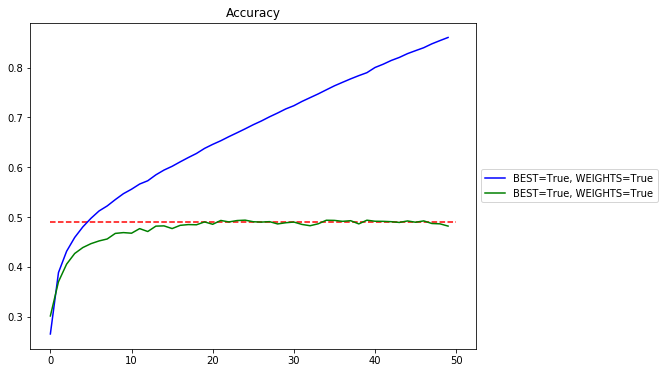

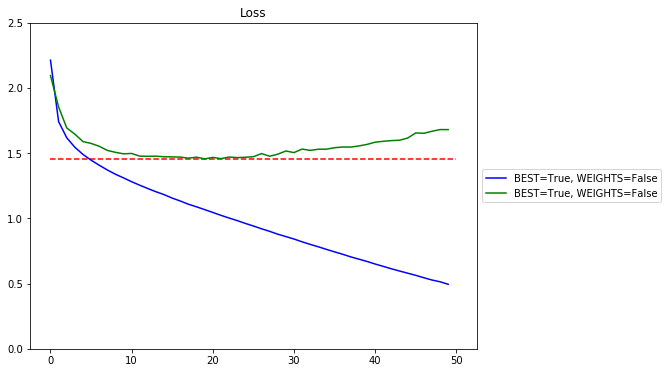

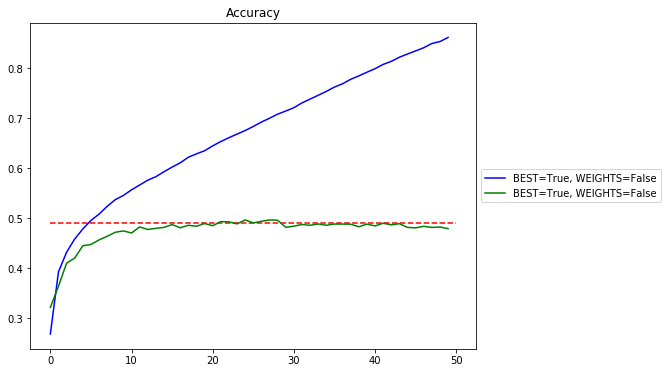

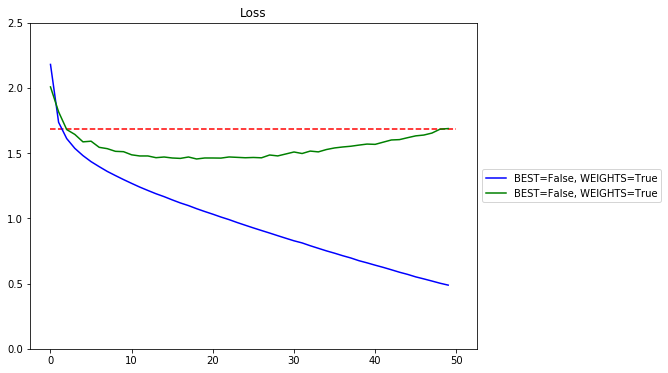

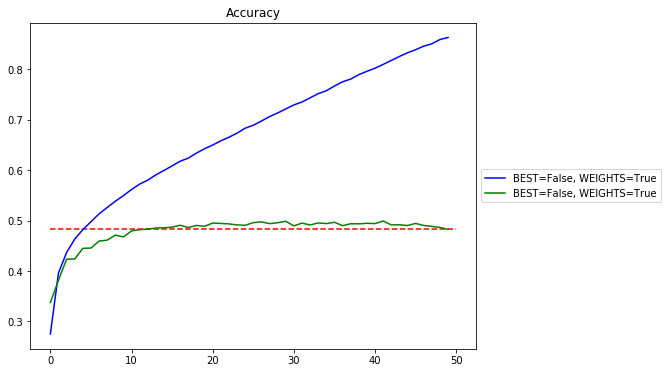

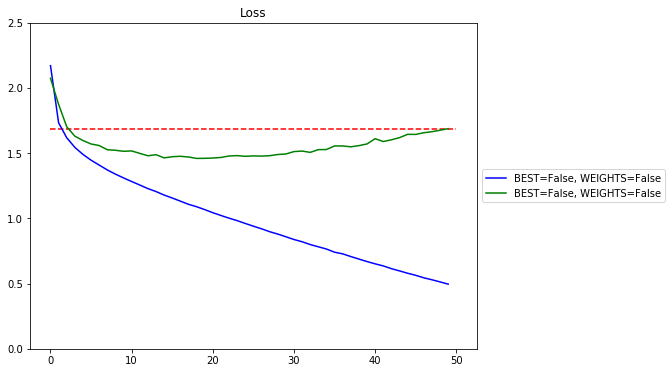

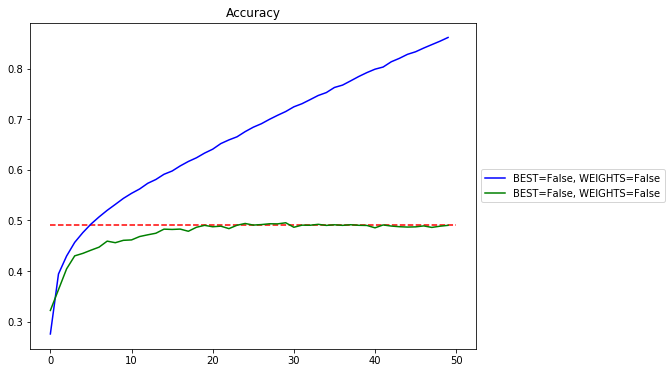

In [60]:
for i, cond in enumerate(results.keys()):
    plot_results(i,cond)

In [65]:
# load weights
keras.backend.clear_session()
model_weights = build_mlp(input_shape=x_train.shape[1:])

In [72]:
model_weights.load_weights("./BEST=True, WEIGHTS=True.h5")
model_weights.summary()
model_weights.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)
y_pred = model_weights.predict(x_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

In [74]:
y_pred

array([[9.0739969e-03, 7.9348288e-02, 1.2533328e-01, ..., 2.2239002e-04,
        2.0390053e-01, 4.6903421e-03],
       [4.4640351e-02, 6.9606103e-02, 3.8179571e-03, ..., 7.2271877e-04,
        7.6698375e-01, 1.1197334e-01],
       [4.1668627e-01, 8.0003031e-02, 1.1980663e-02, ..., 8.9417109e-03,
        3.2870954e-01, 1.4418927e-01],
       ...,
       [3.8377440e-04, 1.2286081e-03, 4.6629950e-01, ..., 5.8050533e-03,
        7.7815880e-03, 2.3327505e-03],
       [2.2700898e-02, 5.5852029e-02, 5.6209892e-02, ..., 6.9429487e-02,
        2.1303445e-02, 1.3984472e-02],
       [3.1303119e-02, 6.4811674e-03, 4.8650265e-02, ..., 4.0686747e-01,
        2.7869718e-02, 1.7185624e-01]], dtype=float32)

In [75]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [76]:
print(len(y_pred),len(y_test))

10000 10000


In [77]:
model_weights.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 68us/step


[1.462070339012146, 0.4903]

In [79]:
print(keras.metrics.categorical_accuracy(y_test, y_pred))

Tensor("Cast_1:0", shape=(10000,), dtype=float32)
